### NOTEBOOK CONTENTS:

1. User Communities detection
2. User Communities EDA
3. User Communities Deep Dive - insights

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import scipy
import networkx as nx
from collections import defaultdict
from itertools import chain

from collections import Counter

Loading Vectos and stuff

In [ ]:
ratings_df = pd.read_csv("/content/drive/MyDrive/movies_big/emb/ratings.csv")

In [ ]:
## Keeping only those users who have given more than 5 ratings and less than 200 
uids, f = np.unique(ratings_df['userId'], return_counts=True)
p = f/sum(f)
np.min(f), np.max(f), np.median(f), np.mean(f)#np.min(f), np.max(f), np.median(f), np.mean(f)
uids = uids[(f<200) & (f>5)]
f = f[(f<200) & (f>5)]
final_uids = np.random.choice(uids, p=f/sum(f), size=30000, replace=False)

In [ ]:
len(np.unique(final_uids))

30000

In [ ]:
import pickle
f_name = "/content/drive/MyDrive/movies_big/emb"
def load_embeddings(f_name):
    with open(f_name+'/u_mat.pkl','rb') as f:
                u_mat = pickle.load(f)
    with open(f_name+'/m_mat.pkl','rb') as f:
                m_mat = pickle.load(f)
    with open(f_name+'/m_ids.pkl','rb') as f:
                m_ids = pickle.load(f)
    with open(f_name+'/u_ids.pkl','rb') as f:
                u_ids = pickle.load(f)
    return m_mat, m_ids, u_mat, u_ids

In [ ]:
m_mat, m_ids, u_mat, u_ids = load_embeddings(f_name)
m_mat.shape, m_ids.shape, u_mat.shape, u_ids.shape
sampled_idxs = [idx for idx, uid in enumerate(u_ids) if uid in final_uids]

((43350, 600), (43350,), (269696, 600), (269696,))

## 1. Creating Graph / Network of users

In [ ]:
from sklearn import metrics
def create_weighted_adjacency_mat(mat, thresh):
    mat[mat<thresh]=0
    return mat

In [ ]:
## Building graph of users
u_ids = u_ids[sampled_idxs]
u_mat = u_mat[sampled_idxs]
u_sim = metrics.pairwise.cosine_similarity(u_mat)

u_sim = create_weighted_adjacency_mat(u_sim, 0.8)
np.fill_diagonal(u_sim, 0)

r_keep_idxs = ~np.all(u_sim == 0, axis=1)
c_keep_idxs = ~np.all(u_sim.T == 0, axis=1)
print("Sanity: ", np.all(r_keep_idxs == c_keep_idxs))

u_sim = scipy.sparse.csr_matrix(u_sim)
u_sim = u_sim[r_keep_idxs]
u_sim = u_sim.T[c_keep_idxs].T

## 2. Community Detection

In [ ]:
G = nx.convert_matrix.from_scipy_sparse_matrix(u_sim)
partition = community_louvain.best_partition(G, weight='weight')
## Modularity metric score
keep_u_ids = u_ids[r_keep_idxs]
community_louvain.modularity(partition, G, weight='weight')

0.34374850116304256

In [ ]:
## Number of communities
np.unique(list(partition.values()))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

## 3. User Communities EDA

In [ ]:
communitites = defaultdict(list)

for key, value in sorted(partition.items()):
    communitites[value].append(keep_u_ids[key])
## reject outlier communities
for i in communitites:
    print(i, len(communitites[i]))

0 3025
1 5147
2 5972
4 3902
14 2
16 2
17 3
19 2
20 3
23 2
18 6
21 3
22 5
25 2
6 2
7 3
8 3
9 2
10 2
11 2
15 2
13 3
24 2
12 3
3 2
5 2


In [ ]:
## Preparing and processing data for distribution plots
user_community_df = pd.DataFrame({'community':communitites.keys(),
              'user_id':communitites.values()
              })

user_community_df = user_community_df.explode('user_id')
user_community_df = user_community_df.merge(ratings_df[['userId', 'movieId', 'rating']], left_on='user_id', right_on='userId')
user_community_df = pd.DataFrame(user_community_df.groupby('user_id').agg({'community': lambda x: x.tolist()[0],
                                          'movieId': lambda x: x.tolist(),
                                          'rating': lambda x: x.tolist()}).rename({
                                              'movieId':'movie_list',
                                              'rating':'rating_list'
                                          }, axis=1).reset_index())
user_community_df.to_csv("/content/drive/MyDrive/movies_big/users/user_community_df.csv", index=False)

In [ ]:
user_community_df.head(1)

,user_id,community,movie_list,rating_list
0,16,0,"[32, 50, 111, 198, 260, 296, 316, 318, 380, 48...","[4.5, 5.0, 5.0, 4.5, 3.5, 5.0, 3.5, 5.0, 4.0, ..."


In [ ]:
community_df = pd.DataFrame(user_community_df.groupby('community').agg({
    'user_id': lambda x: list(x),
    'movie_list': lambda x: list(chain.from_iterable(x)),
    'rating_list': lambda x: list(chain.from_iterable(x))
}).reset_index())

In [ ]:
community_df.head(1)

,community,user_id,movie_list,rating_list
0,0,"[16, 55, 89, 227, 273, 451, 471, 495, 517, 619...","[32, 50, 111, 198, 260, 296, 316, 318, 380, 48...","[4.5, 5.0, 5.0, 4.5, 3.5, 5.0, 3.5, 5.0, 4.0, ..."


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

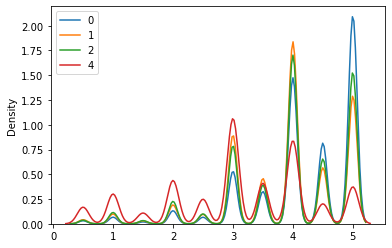

In [ ]:
## Plot distributions
for _,row in community_df.iterrows():
    com = row['community']
    if com in [0,1,2,4]:
        ratings = row['rating_list']
        sns.distplot(ratings, hist=False, label=com)
        plt.legend()
        plt.plot()

In [ ]:
user_community_df['rating_list'] = user_community_df['rating_list'].apply(lambda x: eval(x))
user_community_df['movie_list']=user_community_df['movie_list'].apply(lambda x: eval(x))
user_community_df['avg_user_ratings'] = user_community_df['rating_list'].apply(lambda x: np.mean(x))
user_community_df.head(1)

,user_id,community,movie_list,rating_list,avg_user_ratings
0,16,0,"[32, 50, 111, 198, 260, 296, 316, 318, 380, 48...","[4.5, 5.0, 5.0, 4.5, 3.5, 5.0, 3.5, 5.0, 4.0, ...",4.417582


In [ ]:
from itertools import chain
community_df = pd.DataFrame(user_community_df.groupby('community').agg({
    'user_id': lambda x: list(x),
    'movie_list': lambda x: list(chain.from_iterable(x)),
    'rating_list': lambda x: list(chain.from_iterable(x)),
    'avg_user_ratings': lambda x: list(x.values)
}).reset_index())

In [ ]:
community_df.head(1)

,community,user_id,movie_list,rating_list,avg_user_ratings
0,0,"[16, 55, 89, 227, 273, 451, 471, 495, 517, 619...","[32, 50, 111, 198, 260, 296, 316, 318, 380, 48...","[4.5, 5.0, 5.0, 4.5, 3.5, 5.0, 3.5, 5.0, 4.0, ...","[4.417582417582418, 4.443609022556391, 4.2, 3...."


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

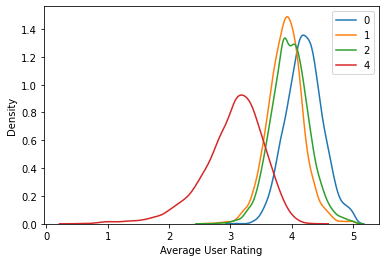

In [ ]:
for _,row in community_df.iterrows():
    com = row['community']
    if com in [0,1,2,4]:
        ratings = row['avg_user_ratings']
        sns.distplot(ratings, hist=False, label=com)
        plt.legend()
        plt.xlabel("Average User Rating")
        plt.plot()

In [ ]:
ratings_df.head(1)

,Unnamed: 0,userId,movieId,rating,timestamp
0,0,1,110,1.0,1425941529


In [ ]:
avg_movie_ratings = ratings_df.groupby('movieId').agg(
    {'rating':lambda x: np.mean(x.values)}
).reset_index()

com_movie_df = community_df[['community','movie_list']].explode('movie_list')
com_movie_df = com_movie_df.merge(avg_movie_ratings, left_on='movie_list', right_on='movieId')

com_movie_df = com_movie_df.groupby('community').agg(
    {'rating': lambda x: list(x.values)}
).reset_index()

In [ ]:
com_movie_df.head(1)

,community,rating
0,0,"[3.888769242293719, 3.888769242293719, 3.88876..."


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

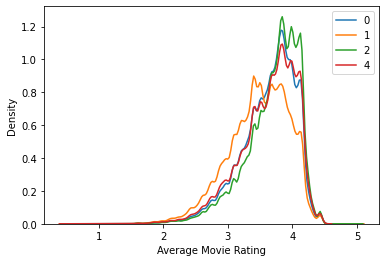

In [ ]:
for _,row in com_movie_df.iterrows():
    com = row['community']
    if com in [0,1,2,4]:
        ratings = row['rating']
        sns.distplot(ratings, hist=False, label=com)
        plt.legend()
        plt.xlabel("Average Movie Rating")
        plt.plot()

## 4. Meta Data Analysis

In [ ]:
m_meta = pd.read_csv("/content/drive/MyDrive/movies_big/movies_metadata.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
m_meta.drop_duplicates(subset=['id'], inplace=True)
m_meta['genres'] = m_meta['genres'].apply(lambda x: eval(x))
m_meta.dropna(subset=['title'], inplace=True)
m_meta['production_companies'] = m_meta['production_companies'].apply(lambda x: eval(x))
m_meta['id'] = m_meta['id'].astype(int)
m_meta.dropna(subset=['imdb_id'], inplace=True)
m_meta['imdbId']=m_meta['imdb_id'].apply(lambda x: int(x.replace("tt", "")))
m_meta['genre_list'] = m_meta['genres'].apply(lambda x:  [g['name'] for g in x])

In [ ]:
m_meta.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,imdbId,genre_list
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,114709,"[Animation, Comedy, Family]"


In [ ]:
links_df = pd.read_csv("/content/drive/MyDrive/movies_big/emb/links.csv")
temp_df = community_df[['community', 'movie_list']].explode('movie_list')
temp_df = temp_df.merge(links_df, left_on='movie_list', right_on='movieId').merge(m_meta[['imdbId','genre_list']], on='imdbId')

Contribution of genres across movie communities

In [ ]:
temp_df = temp_df[['community','genre_list']].groupby('community').agg({
    'genre_list': lambda x: Counter(list(chain.from_iterable(x.values)))
}).reset_index()

Community:  0


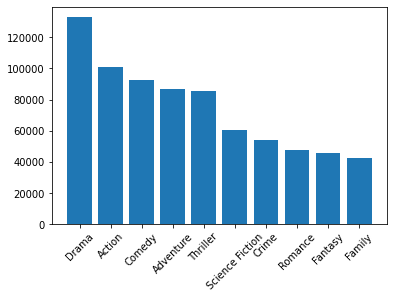

Community:  1


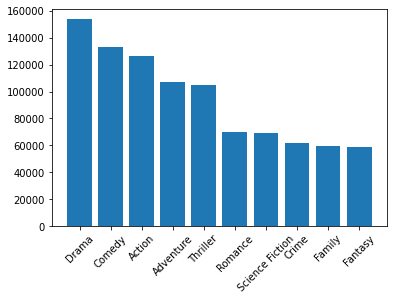

Community:  2


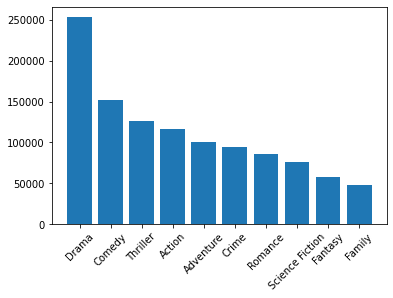

Community:  4


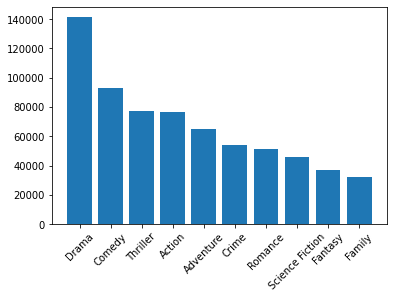

In [ ]:
for _,row in temp_df.iterrows():
    c = row['community']
    
    if c in [0,1,2,4]:
        print("Community: ", c)
        temp = row['genre_list'].most_common(10)
        plt.bar([t[0] for t in temp], [t[1] for t in temp])
        plt.xticks(rotation=45)
        plt.show()


## -1. GSP (Non fruitful experimentation)

In [ ]:
#user_community_df = pd.read_csv("/content/drive/MyDrive/movies_big/users/user_community_df.csv")
#ratings_df = pd.read_csv("/content/drive/MyDrive/movies_big/emb/ratings.csv")
#user_community_df.head(1)
# user_history = ratings_df[ratings_df['userId'].isin(user_community_df['user_id'])]
# user_history = user_history[user_history['rating']>4].reset_index()
# user_history['movie_time'] = user_history[['movieId', 'timestamp']].apply(lambda x: (x[0], x[1]), axis=1)
# user_history = user_history.groupby('userId').agg({
#     'movie_time': lambda x: sorted(list(x.values), key=lambda k: k[1])
# }).reset_index()
# user_history['sorted_movie_ids'] = user_history['movie_time'].apply(lambda x: [i[0] for i in x])

# from gsppy.gsp import GSP
# result = GSP(user_history['sorted_movie_ids'].values).search(0.05)
# joblib.dump(result, "/content/drive/MyDrive/movies_big/gsp_result_0.05.pkl")